In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import numpy as np
import pandas as pd

import SequenceDataORM as sqd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///NS001_evolved_mutations_copy2.db', echo=False) # our database connection
session = sessionmaker(bind=engine)() # the session object is how we make queries through sqlalchemy

We have a rough test of how reliable our sequence data in combination with BreSeq's mutation inference is in the form of 3 sequenced samples of NS001. By comparing mutations and their frequencies in these samples with each other, we can get some idea of how much we can rely on any individual sequenced sample.

We also aggregated all 3 samples data together before running the data through breseq which gives us a very high coverage sequencing (~200x), but not an independent datapoint from the three samples. This aggregation of samples served to create the reference sequence that all samples were compared against to detect new mutations and polymorphisms (this means the aggregate sample was checked against itself by breseq to measure polymorphisms).

# Are there any differences in fixed mutations detected between the three samples and their aggregate? No.

This can be determined by glancing at the original html output of breseq or by a few calls to the sql database, but the answer is straightforward and ideal so we'll move on to considering polymorphisms

# Are there any differences in polymorphisms detected among the three ancestral NS001 samples and their aggregate? Yes.

This is not easy to see by glancing at breseq's html output, and can be quantified so let's proceed to query the data.

In [3]:
aggregate_snps = [snp for snp in session.query(sqd.SNP_Mutation) if 'Aggregate_NS001_Ancestors' in snp.samples]
anc1_snps = [snp for snp in session.query(sqd.SNP_Mutation) if 'Ancestor_S1' in snp.samples]
anc2_snps = [snp for snp in session.query(sqd.SNP_Mutation) if 'Ancestor_S2' in snp.samples]
anc3_snps = [snp for snp in session.query(sqd.SNP_Mutation) if 'Ancestor_S3' in snp.samples]

For example, the mutations found in the aggregated samples are

In [4]:
aggregate_snps

[<SNP_Mutation(chr_position=102236, ref_base=A, new_base=G, gene=murC|ddlB)>,
 <SNP_Mutation(chr_position=152255, ref_base=G, new_base=A, gene=yadM)>,
 <SNP_Mutation(chr_position=155269, ref_base=T, new_base=C, gene=htrE)>,
 <SNP_Mutation(chr_position=327888, ref_base=A, new_base=G, gene=betB)>,
 <SNP_Mutation(chr_position=419369, ref_base=T, new_base=C, gene=brnQ)>,
 <SNP_Mutation(chr_position=547336, ref_base=C, new_base=T, gene=fdrA)>,
 <SNP_Mutation(chr_position=735938, ref_base=A, new_base=G, gene=ybfQ/ybfL)>,
 <SNP_Mutation(chr_position=1055424, ref_base=A, new_base=T, gene=torS/torT)>,
 <SNP_Mutation(chr_position=1171667, ref_base=A, new_base=G, gene=mfd)>,
 <SNP_Mutation(chr_position=1541878, ref_base=A, new_base=G, gene=narZ/narU)>,
 <SNP_Mutation(chr_position=1733676, ref_base=T, new_base=C, gene=mepH)>,
 <SNP_Mutation(chr_position=1851805, ref_base=T, new_base=C, gene=pncA/ydjE)>,
 <SNP_Mutation(chr_position=2747257, ref_base=G, new_base=A, gene=ffh)>,
 <SNP_Mutation(chr_pos

How many mutations are found in each of these?

In [5]:
print('aggregate_snps: {0}'.format(len(aggregate_snps)))
print('ancestor1_snps: {0}'.format(len(anc1_snps)))
print('ancestor2_snps: {0}'.format(len(anc2_snps)))
print('ancestor3_snps: {0}'.format(len(anc3_snps)))

aggregate_snps: 24
ancestor1_snps: 22
ancestor2_snps: 32
ancestor3_snps: 27


More polymorphisms were detected in ancestor2 and ancestor3 than in the aggregated data. This must be due to some feature of BreSeq. But the number of polymorphisms alone doesn't tell us how much divergence there is between samples/BreSeq runs. We should check how many of the polymorphisms are found in every sample. To do this, we can just take the intersection of the set of mutations for each sample and the aggregate.

In [6]:
always_found_mutations = set(aggregate_snps) & set(anc1_snps) & set(anc2_snps) & set(anc3_snps)
for mutation in always_found_mutations:
    print(mutation)

<SNP_Mutation(chr_position=327888, ref_base=A, new_base=G, gene=betB)>
<SNP_Mutation(chr_position=102236, ref_base=A, new_base=G, gene=murC|ddlB)>
<SNP_Mutation(chr_position=4397411, ref_base=G, new_base=C, gene=amiB/mutL)>
<SNP_Mutation(chr_position=3437557, ref_base=A, new_base=G, gene=trkA)>
<SNP_Mutation(chr_position=3629956, ref_base=T, new_base=C, gene=yhiI)>
<SNP_Mutation(chr_position=155269, ref_base=T, new_base=C, gene=htrE)>
<SNP_Mutation(chr_position=2747257, ref_base=G, new_base=A, gene=ffh)>


So only 7 mutations are found in every sample sequenced and in the aggregate. Given that the smallest number of mutations called by BreSeq was 22, this isn't great. But is BreSeq over or under sensitive or both? Dealing with sequence data is a hard problem. Let's see what the total number of distinct mutations is by unioning the set of mutations for each sample and the aggregate.

In [7]:
all_NS001_mutations = set(aggregate_snps) | set(anc1_snps) | set(anc2_snps) | set(anc3_snps)
print('There are {0} mutations detected in the ancestor'.format(len(all_NS001_mutations)))

There are 63 mutations detected in the ancestor


Given the number of mutations detected in each sample and the aggregate and that 7 mutations were shared by all, that number could have been as high as 85. 63 isn't a lot less, but it's not maximally bad. We might want to ignore any mutations that are only detected in one sample. What's the set of mutations found in at least two samples?

In [8]:
at_least_2 = ((set(aggregate_snps) & set(anc1_snps)) |
              (set(aggregate_snps) & set(anc2_snps)) |
              (set(aggregate_snps) & set(anc3_snps)) |
              (set(anc1_snps) & set(anc2_snps)) |
              (set(anc1_snps) & set(anc3_snps)) |
              (set(anc2_snps) & set(anc3_snps)))

print('There are {0} mutations found in at least 2 samples or a sample and the aggregate.'.format(len(at_least_2)))


There are 19 mutations found in at least 2 samples or a sample and the aggregate.


So 19 out of 63 mutations are found in either two samples or one sample and the aggregate of all samples. If we remove the aggregate from consideration (since it does after all contain every sample in its data)

In [9]:
at_least_2_r = ((set(anc1_snps) & set(anc2_snps)) |
              (set(anc1_snps) & set(anc3_snps)) |
              (set(anc2_snps) & set(anc3_snps)))

print('There are {0} mutations found in at least 2 samples.'.format(len(at_least_2_r)))

There are 17 mutations found in at least 2 samples.


Not much changes.

# How similar are the three samples of the ancestor NS001 to each other and to their aggregate? How similar are any two samples to each other?

To compare samples of NS001 we'll find the correlation between the SNP frequencies of the two samples as measured by BreSeq. If Illumina sequencing and BreSeq were perfect, we'd find that the gene frequencies matched perfectly and the correlation would be 1.

To lower the noise somewhat, we're going to only consider SNP's found in at least 2 samples or that passed the threshold of a sample and the aggregate.

In [10]:
NS001_samples = [sample for sample in session.query(sqd.DNA_Sample)
                                       .filter(sqd.DNA_Sample.name.in_(['Aggregate_NS001_Ancestors',
                                                                        'Ancestor_S1',
                                                                        'Ancestor_S2',
                                                                        'Ancestor_S3']))]
ancestral_snps = list(at_least_2)
snp_frequencies = np.zeros(shape=(len(ancestral_snps),len(NS001_samples)),dtype='float')
for i, snp in enumerate(ancestral_snps):
    for j, sample in enumerate(NS001_samples):
        snp_frequencies[i,j] = sample.snp_mutation_frequency(snp, session)

snp_frequencies_df = pd.DataFrame(data=snp_frequencies,
                                  index=[snp.chr_position for snp in ancestral_snps],
                                  columns=[sample.name for sample in NS001_samples])

Here we have a heatmap of the frequencies of each mutation (named by its position on the chromosome) in each ancestral NS001 sample.

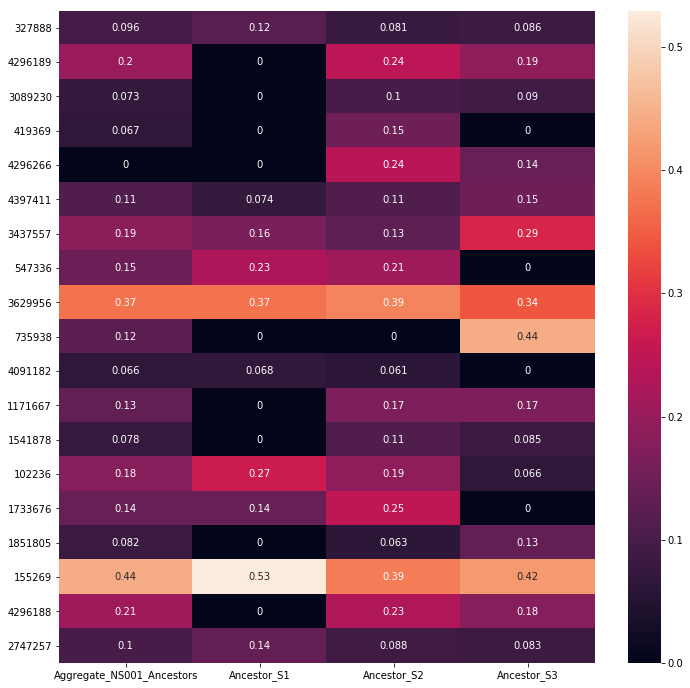

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(snp_frequencies_df, annot=True)

In [12]:
snp_frequencies_df.corr()

,Aggregate_NS001_Ancestors,Ancestor_S1,Ancestor_S2,Ancestor_S3
Aggregate_NS001_Ancestors,1.000000,0.814416,0.750714,0.638503
Ancestor_S1,0.814416,1.000000,0.657271,0.358525
Ancestor_S2,0.750714,0.657271,1.000000,0.275170
Ancestor_S3,0.638503,0.358525,0.275170,1.000000


The frequencies of mutations across samples are correlated, but Ancestor_S3 is poorly correlated with the other 2 in comparison.

What if we were to compare the gene frequencies of every mutation found in any sample for every sample? Would the ancestors stand out as being particularly correlated with each other like we'd hope?

In [13]:
all_samples = [sample for sample in session.query(sqd.DNA_Sample)]
all_samples = all_samples[1:] + [all_samples[0]]
all_snps = [snp for snp in session.query(sqd.SNP_Mutation)]

all_snp_frequencies = np.zeros(shape=(len(all_snps),len(all_samples)),dtype='float')
for i, snp in enumerate(all_snps):
    for j, sample in enumerate(all_samples):
        all_snp_frequencies[i,j] = sample.snp_mutation_frequency(snp, session)

all_snp_frequencies_df = pd.DataFrame(data=all_snp_frequencies,
                                  index=[snp.chr_position for snp in all_snps],
                                  columns=[sample.name for sample in all_samples])

I've chosen a diverging heatmap, so you can easily see the contrast between weaker correlations (almost all samples are positively correlated in gene frequencies because they are all related) and stronger correlations (like the 3 replicates of the ancestor NS001 or the same evovling replicate of the experiment at two different times)

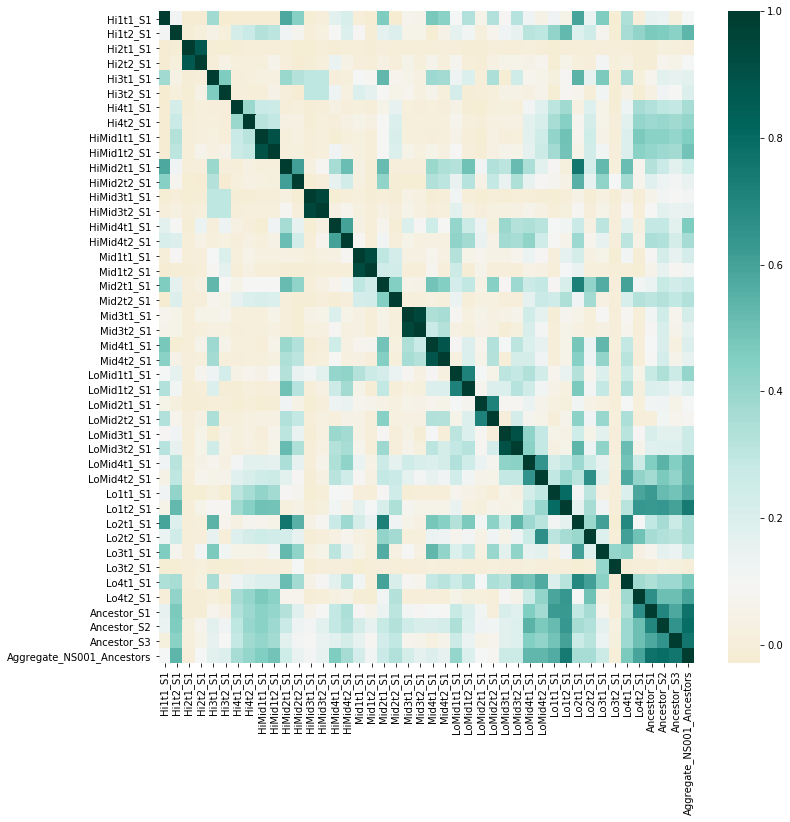

In [14]:
plt.figure(figsize=(12,12))
sns.heatmap(all_snp_frequencies_df.corr(), center=.1,cmap='BrBG', annot=False)

You'll notice that most of the correlations are <.5 or so except for strong correlations just off the diagonal of each sample with it ancestor in the same well and for the three replicate ancestral NS001 samples and the aggregated sample in the bottom right corner.

However, there are some samples separated by hundreds of generations that are well correlated with each other. Almost as well as a pair of replicate ancestral NS001 samples (which are only separated by ~10 generations it takes to grow a tube from frozen stock). So sequencing at this depth and using these tools to analyze the data gives good data, but we couldn't guarantee that we could easily figure out which samples were replicates if we were analyzing the data blind.

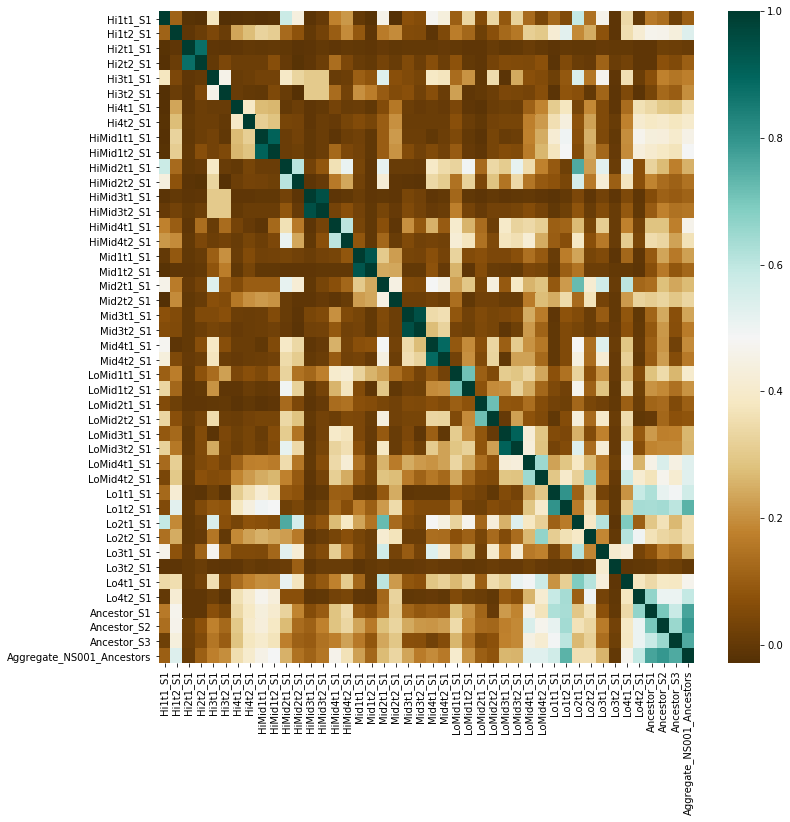

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(all_snp_frequencies_df.corr(), cmap='BrBG', annot=False)